# Description - Prepare Data for NBS Analysis on Matlab

This notebook prepares connectivity matrices for doing the NBS analyses on Matlab. At this point we have selected scans corresponding to the two populations that we want to compare and all that's left is to generate the design matrices and create a copy of the FC matrices in a format that NBS can understand.

In [1]:
import os.path as osp
import os
import pandas as pd
import numpy as np
import xarray as xr
from sfim_lib.io.afni import load_netcc
from shutil import rmtree
from tqdm import tqdm
from IPython import display

In [2]:
from utils.basics import RESOURCES_NBS_DIR, ATLASES_DIR, DATA_DIR, SNYCQ_CLUSTERS_INFO_PATH
from utils.basics import FB_400ROI_ATLAS_NAME, FB_400ROI_ATLAS_PATH, FB_400ROI_BRAINNET_NODES_PATH
from utils.basics import get_sbj_scan_list

In [3]:
print("++ INFO: RESOURCES_NBS_DIR=%s" % RESOURCES_NBS_DIR)

++ INFO: RESOURCES_NBS_DIR=/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs


If the folder where we want to sace the outputs/inputs for NBS does not exists, we create it.

>**NOTE:** If the folder already exists, it will delete its contents and you will have to re-run the NBS portion of the analyses

In [4]:
if not osp.exists(RESOURCES_NBS_DIR):
    os.makedirs(RESOURCES_NBS_DIR)
    print('++ INFO: Created folder [%s]' % RESOURCES_NBS_DIR)
for ATLAS_NAME in [FB_400ROI_ATLAS_NAME]:
    folder_name = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME)
    if osp.exists(folder_name):
        rmtree(folder_name)
        print('++ WARNING: Removing pre-existing folder [%s]' % folder_name)
    os.makedirs(folder_name)
    print('++ INFO: Regenerating empty folder [%s]' % folder_name)

++ WARNING: Removing pre-existing folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2]
++ INFO: Regenerating empty folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2]


# 1. Create input files for NBS and BrainNet packages

These two software requires a few additional files with information about ROI names, centroids and labels. We generate those next for the two atlases of interest:

* ```<ATLAS_NAME>_BrainNet_Nodes.node```: Information about ROI names and centroids for BrainNet.
* ```<ATLAS_NAME>_NBS_Node_Coordinates.txt```: ROI centroids in NBS format.
* ```<ATLAS_NAME>_NBS_Node_Labels.txt```: ROI names in NBS format.

In [5]:
Nw2Id = {'Vis':1,'SomMot':2,'DorsAttn':3,'SalVentAttn':4,'Limbic':5,'Cont':6,'Default':7,'Subcortical':8}

In [6]:
roi_info,Nrois={},{}
for ATLAS_NAME,BRAINNET_NODES_PATH  in zip([FB_400ROI_ATLAS_NAME],[FB_400ROI_BRAINNET_NODES_PATH]):
    # Load necessary info in memory
    # =============================
    ATLASINFO_PATH       = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
    roi_info[ATLAS_NAME] = pd.read_csv(ATLASINFO_PATH)
    Nrois[ATLAS_NAME]    = roi_info[ATLAS_NAME].shape[0]
    # Create Brainnet Nodes data structure
    # ====================================
    BRAINNET_NODES_df               = roi_info[ATLAS_NAME][['pos_R','pos_A','pos_S','ROI_Name']].copy()
    BRAINNET_NODES_df['Node Size']  = 1
    BRAINNET_NODES_df['Node Color'] = [Nw2Id[n.split('_')[1]] for n in BRAINNET_NODES_df['ROI_Name']]
    BRAINNET_NODES_df = BRAINNET_NODES_df[['pos_R','pos_A','pos_S','Node Color','Node Size','ROI_Name']]
    # Save to disk
    # ============
    BRAINNET_NODES_df.to_csv(BRAINNET_NODES_PATH, sep=' ', index=None, header=None)
    print('++ INFO: BrainNet_Node file written to disk:   [%s]' % BRAINNET_NODES_PATH)
    # Save coordinate file to disk for NBS
    # ====================================
    coor_file_path = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'{ATLAS_NAME}_NBS_Node_Coordinates.txt'.format(ATLAS_NAME=ATLAS_NAME))
    BRAINNET_NODES_df[['pos_R','pos_A','pos_S']].to_csv(coor_file_path, sep=' ', index=None, header=None)
    print("++ INFO: NBS Coordinate file written to disk: [%s]" % coor_file_path)
    # Save label file to disk for NBS
    # ===============================
    label_file_path = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'{ATLAS_NAME}_NBS_Node_Labels.txt'.format(ATLAS_NAME=ATLAS_NAME))
    BRAINNET_NODES_df['ROI_Name'].to_csv(label_file_path, sep=' ', index=None, header=None)
    print("++ INFO: NBS Label file written to disk:      [%s]" % label_file_path)
    print("++ =====================================")

++ INFO: BrainNet_Node file written to disk:   [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/Schaefer2018_400Parcels_7Networks_AAL2_BrainNet_Nodes.node]
++ INFO: NBS Coordinate file written to disk: [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/Schaefer2018_400Parcels_7Networks_AAL2_NBS_Node_Coordinates.txt]
++ INFO: NBS Label file written to disk:      [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/Schaefer2018_400Parcels_7Networks_AAL2_NBS_Node_Labels.txt]
++ =====================================


***
# 2. Create Design Matrix for NBS

First, we load the cluster membership information generated in ```S12_SNYCQ_Clustering_Confounds```

In [7]:
clusters_info = pd.read_csv(SNYCQ_CLUSTERS_INFO_PATH, index_col=['Subject','Run'])

Second, we confirm that we have three clusters

In [8]:
N_clusters = len(clusters_info['Cluster ID'].unique())
print("++ INFO: Number of Clusters = %d clusters" % N_clusters)

++ INFO: Number of Clusters = 3 clusters


Third, we create a dictionary that will contain the scan_IDs for each of the three clusters

In [9]:
scans_per_cluster={cl_label:clusters_info[clusters_info['Cluster Label']==cl_label].index for cl_label in ['Image-Pos-Others','Surr-Neg-Self','Intermediate']}

Forth, we print again the number of scans per cluster, as a sanity check

In [10]:
[(k,i.shape) for k,i in scans_per_cluster.items()]

[('Image-Pos-Others', (81,)),
 ('Surr-Neg-Self', (78,)),
 ('Intermediate', (312,))]

Fifth, we generate the design matrix taking into accoun only the scans that we use in this part of the analysis (namely those in clusters ```Large F1``` and ```Large F2```)

In [11]:
DESIGN_MATRIX = np.vstack([np.tile(np.array([1,0]),(len(scans_per_cluster['Image-Pos-Others']),1)),
                           np.tile(np.array([0,1]),(len(scans_per_cluster['Surr-Neg-Self']),1))])
DESIGN_MATRIX_PATH = osp.join(RESOURCES_NBS_DIR,'NBS_CL02_DesingMatrix.txt')
np.savetxt(DESIGN_MATRIX_PATH,DESIGN_MATRIX,delimiter=' ',fmt='%d')
print('++ INFO: Design Matrix for 2 Cluster solution saved in [%s]' % DESIGN_MATRIX_PATH)
print('++ INFO: Design Matrix for 2 Cluster solution has shape [%s]' % str(DESIGN_MATRIX.shape))

++ INFO: Design Matrix for 3 Cluster solution saved in [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/NBS_CL02_DesingMatrix.txt]
++ INFO: Design Matrix for 3 Cluster solution has shape [(159, 2)]


***
# 3. Create Copies of Scan-wise FC Matrices in NBS folders

Count how many scans we have in total across the two clusters of interest

In [12]:
#_,scans_list = get_sbj_scan_list(when='post_motion', return_snycq=False)
Nscans       = clusters_info.set_index('Cluster Label').loc[['Image-Pos-Others','Surr-Neg-Self']].shape[0]
print(Nscans)

159


## 3.1. Load all FC matrices into a XR.DataArray 

In [13]:
%%time
sfc_Z_xr={}
for ATLAS_NAME in [FB_400ROI_ATLAS_NAME]:
    # Create Empty Numpy Array where to hold all FC matrices. At the end we will move this into an Xarray
    # ===================================================================================================
    sfc_Z_arr = np.empty((Nscans,Nrois[ATLAS_NAME],Nrois[ATLAS_NAME])) * np.nan
    scan_idx      = 0
    scan_name_idx = []
    # For all clusters of interest
    # ============================
    for cluster_id in ['Image-Pos-Others','Surr-Neg-Self']:
        # For each scan in a given cluster
        # ================================
        for sbj,run in scans_per_cluster[cluster_id]:
            # Load FC matrix from disk
            # ========================
            scan_name_idx.append('.'.join([sbj,run]))
            _,_,sesID,_,runID,_,acqID = run.split('-')
            sfc_path = osp.join(DATA_DIR,'PrcsData',sbj,'preprocessed','func','pb06_staticFC','{acqID}_run-{runID}.{ATLAS_NAME}_000.netcc'.format(acqID=acqID,runID=runID, ATLAS_NAME=ATLAS_NAME))
            aux_cc_r = load_netcc(sfc_path)
            # Apply Fisher's transformation
            # =============================
            aux_cc_Z = aux_cc_r.apply(np.arctanh)
            np.fill_diagonal(aux_cc_Z.values,1)
            sfc_Z_arr[scan_idx,:,:] = aux_cc_Z
            # Update counter
            # ==============
            scan_idx = scan_idx + 1
            del aux_cc_r, aux_cc_Z
    # Save all FC matrixes for a given atlas in XR.Array Form
    # =======================================================
    sfc_Z_xr[ATLAS_NAME] = xr.DataArray(sfc_Z_arr,
                        dims=['scan','roi_x','roi_y'],
                        coords={'scan':scan_name_idx,
                                'roi_x':roi_info[ATLAS_NAME]['ROI_ID'],
                                'roi_y':roi_info[ATLAS_NAME]['ROI_ID']})
    del sfc_Z_arr

CPU times: user 4.58 s, sys: 462 ms, total: 5.04 s
Wall time: 11.4 s


## 3.2. Create Data Folder for this solution

Once more, to make sure all things are consistent, we will create empty folders before we start copying the scan-wise FC matrices

In [14]:
for ATLAS_NAME in [FB_400ROI_ATLAS_NAME]:
    NBS_CL02_matrices_folder = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'NBS_CL02_Data')
    print("++ WARNING: Removing pre-existing folder [%s]" % NBS_CL02_matrices_folder)
    if osp.exists(NBS_CL02_matrices_folder):
        rmtree(NBS_CL02_matrices_folder)
    os.mkdir(NBS_CL02_matrices_folder)
    print("++ INFO: Creating empty folder [%s]" % NBS_CL02_matrices_folder)

++ WARNING: Removing pre-existing folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_Data]
++ INFO: Creating empty folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_Data]


## 3.3. Make copies of matrices into the folder

In [15]:
%%time
for ATLAS_NAME in tqdm([FB_400ROI_ATLAS_NAME], desc='Atlas'):
    NBS_CL02_matrices_folder = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'NBS_CL02_Data')
    for i,item in enumerate(list(sfc_Z_xr[ATLAS_NAME].indexes['scan'])):
        dest_path = osp.join(NBS_CL02_matrices_folder,'subject{id}.txt'.format(id=str(i+1).zfill(3)))
        np.savetxt(dest_path,sfc_Z_xr[ATLAS_NAME].loc[item,:,:],delimiter=' ',fmt='%f')

Atlas: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.81s/it]

CPU times: user 4.48 s, sys: 79.9 ms, total: 4.56 s
Wall time: 4.82 s


In [16]:
NBS_CL02_matrices_folder

'/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_Data'

# 4. Run NBS Analysis in Matlab

1. Open Matlab

2. Load the Path to NBS

```addpath(genpath('/data/SFIMJGC_HCP7T/hcp7t_fv_sleep_extraSW/NBS1.2/'))```

3. Configure NBS appropriately for each of the contrasts

    a. Image-Pos-Others
    
    * ```Design Matrix = /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/NBS_CL02_DesingMatrix.txt```
    * ```Contrast = [1,-1]```
    * ```Statistical Test = T-test```
    * ```Threshold = 3.1``` equivalent to p<0.001
    * ```Connectivity Matrices = /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_Data/subject0001.txt```
    * ```Node Coordinates = /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/Schaefer2018_400Parcels_7Networks_AAL2_NBS_Node_Coordinates.txt```
    * ```Node Labels = /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/Schaefer2018_400Parcels_7Networks_AAL2_NBS_Node_Labels.txt```
    * ```Permutations = 5000```
    * ```Significance = 0.05```
    * ```Method = Network-Based Statistics (NBS)```
    * ```Component Size = Extent```
    
    Once the program finish, please save the results as: ```/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_Results/NBS_CL02_Image-Pos-Others_gt_Surr-Neg-Self.mat```

    b. Surr-Neg-Self
    
    Same as above, except for contast, please use ```Contrast = [-1,1]```
    
    And save results as ```/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/Schaefer2018_400Parcels_7Networks_AAL2/NBS_CL02_Results/NBS_CL02_Surr-Neg-Self_gt_Image-Pos-Others.mat```


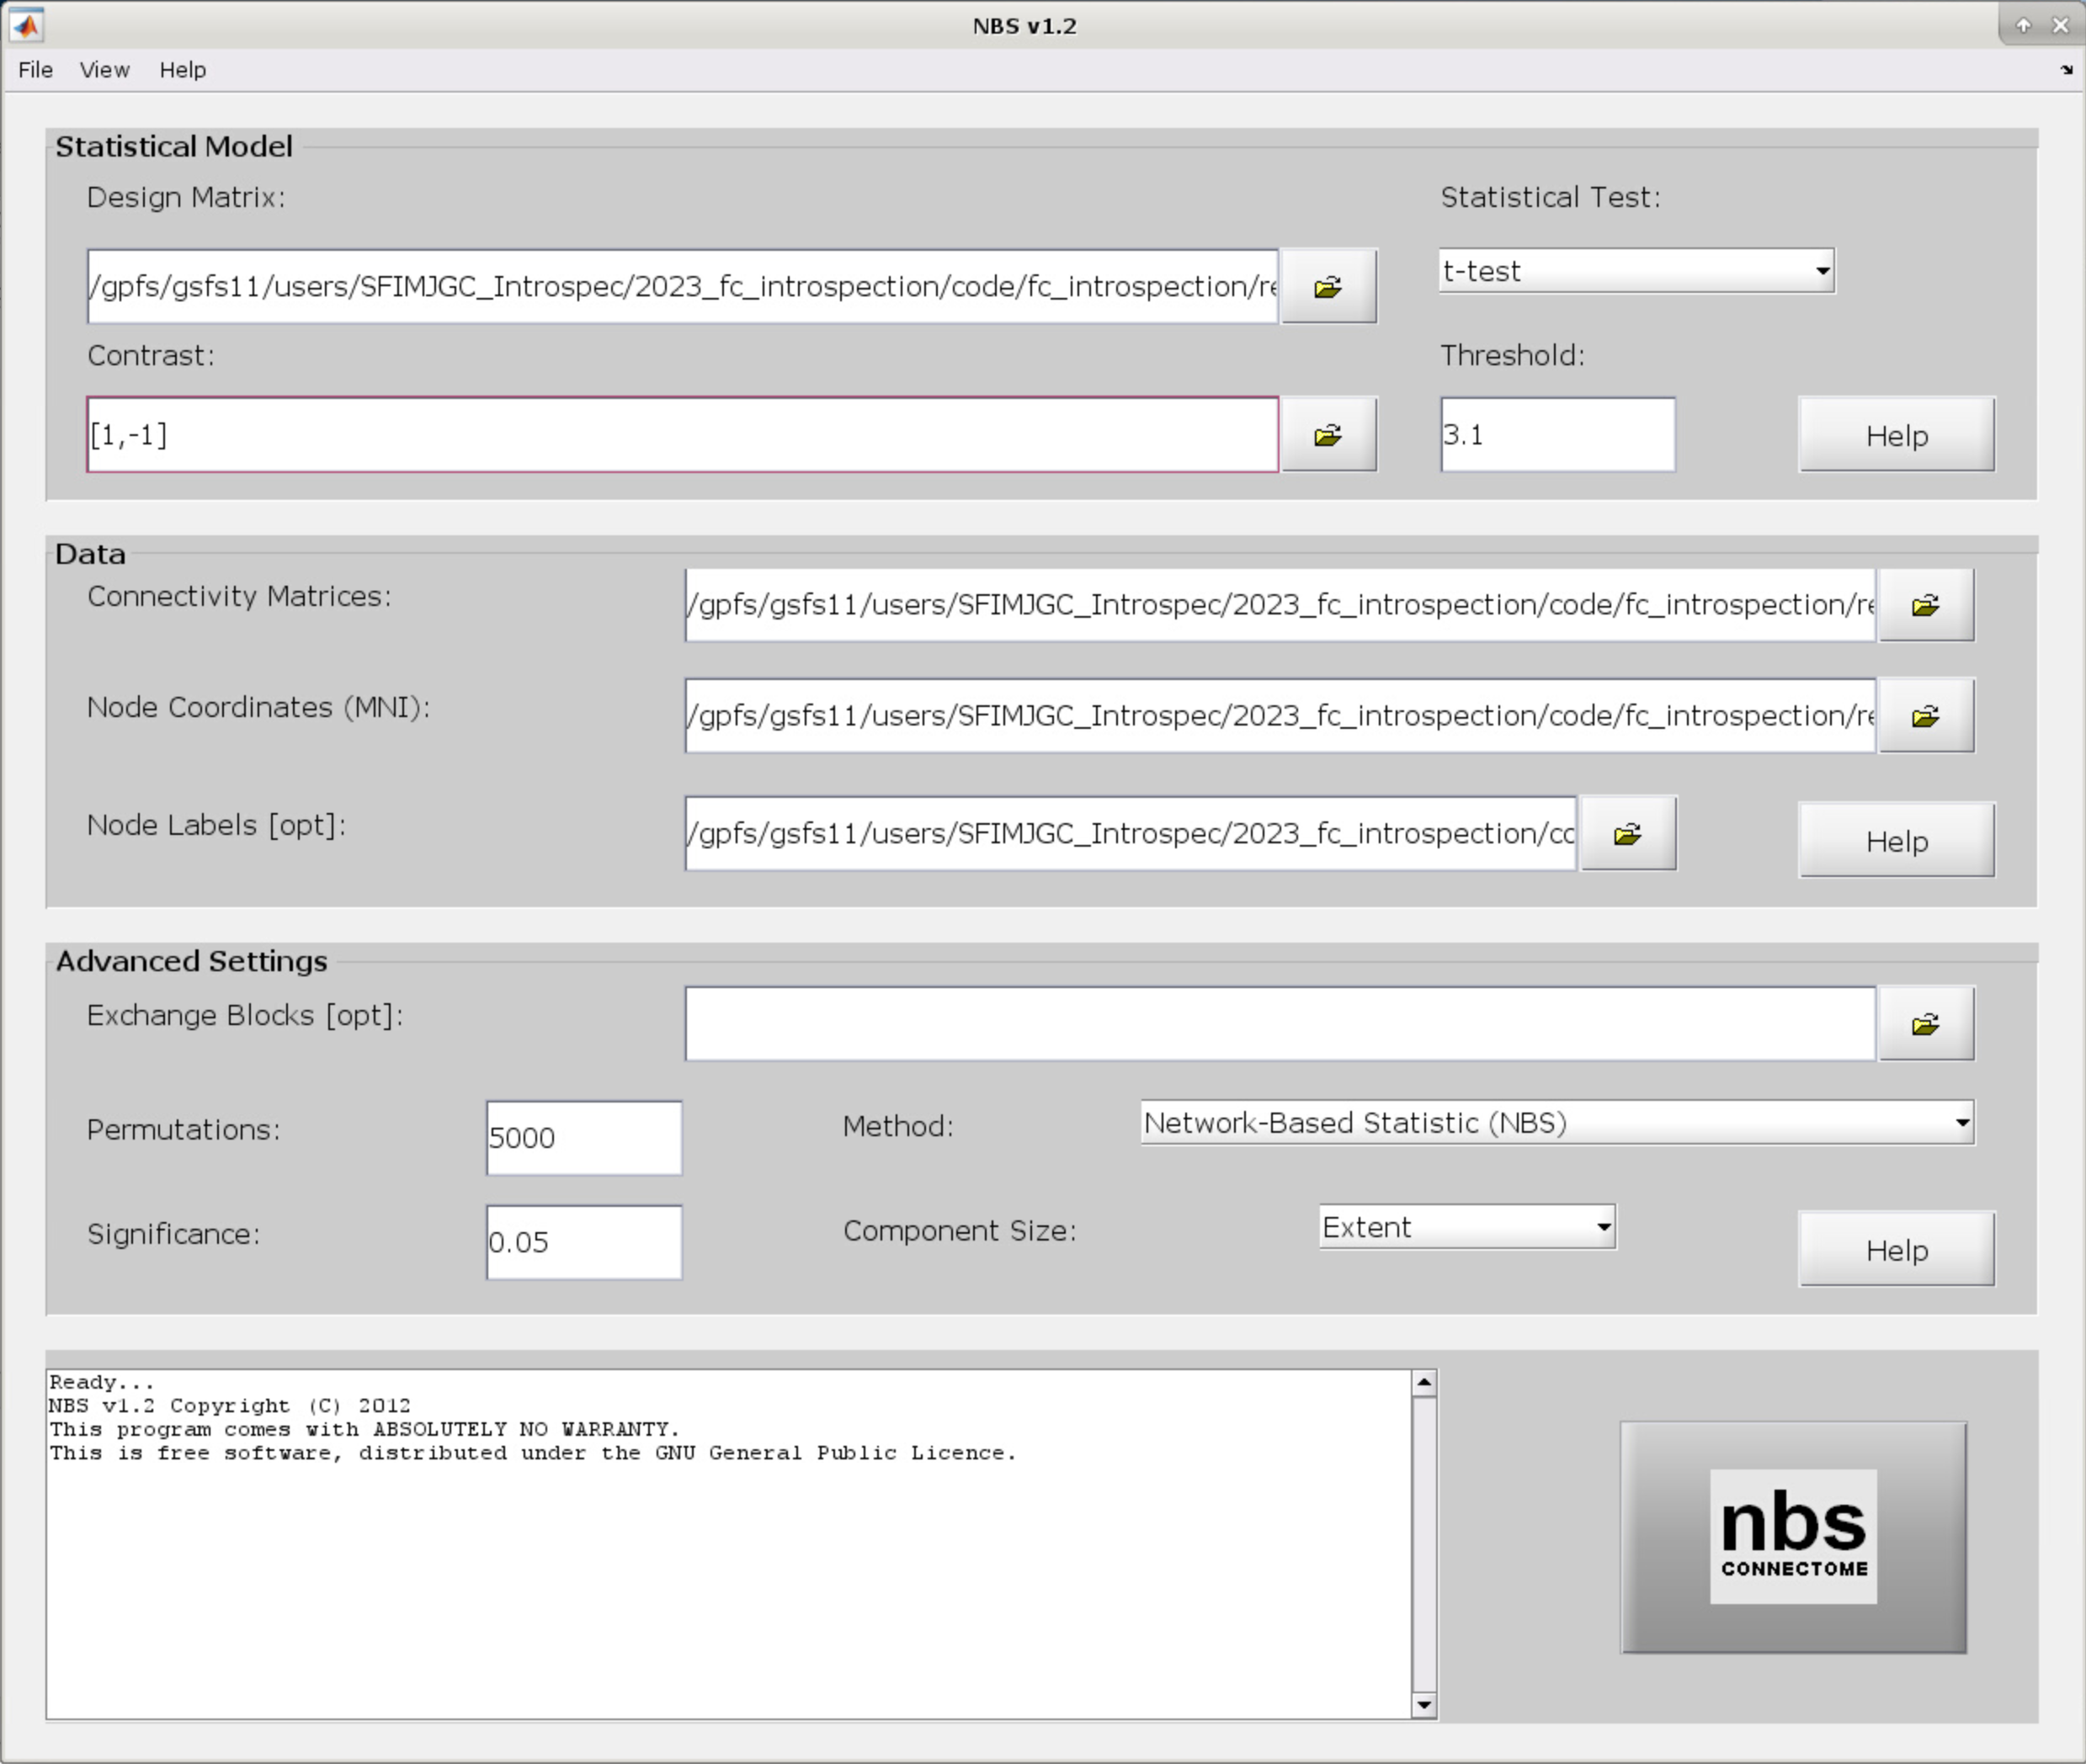

In [20]:
display.Image('./figures/S13_NBS_Configuration.png', width=1200)